This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [2]:
import sys
sys.path.append('..')
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *

import optuna
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

# Data Pre-Processing

In [3]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v2.csv',
        cols=['ppt_2013', 'water_dist', 'hydraulic_c','median_hse', 'dem', 'flow'], is_balanced=True)

balancing...
repairs: 7.6567198704603285%, non-repairs: 92.34328012953968%
processing soil hydraulic data...
acquiring housing information...
processing DEM and flow information...


# Baseline Comparison

In [4]:
train_x, test_x, train_y, test_y = train_test_split(df[['water_dist_norm', 'ppt_2013_norm', 'hydraulic_c_norm', 'median_hse_norm', 'flow_norm', 'dem_norm']], 
                                                    df['sewageSystem_enc'], 
                                                    test_size=0.1, 
                                                    random_state=42)

### a) Aggregate Bayesian

\begin{equation*}
Y \sim Bernoulli(\theta)\tag{1}
\end{equation*}

\begin{equation*}
\theta = \sigma(\beta_{c} + \beta_{w}.waterdist + \beta_{p}.precip + \beta_{h}.hydraulics + \beta_{s}.hseval + \beta_{t}.elev) \tag{2}
\end{equation*}

\begin{equation*}
\textbf{Intercept parameters}\\
    \beta_{c} \sim N_{c}(\mu=\mu_{c}, \sigma=\theta_{c})\\
    \text{where }\mu_{c} \sim N(\mu=0, \sigma=10) \quad and \quad \theta_{c} \sim HN(\sigma=10) \tag{3}
\end{equation*}

\begin{equation*}
\textbf{Precipitation parameters}\\
    \beta_{p} \sim N_{p}(\mu=\mu_{p}, \sigma=\sigma_p)\\
    \text{where }\mu_{p} \sim N(\mu=0, \sigma=10) \quad and \quad \sigma_p \sim HN(\sigma=10) \tag{4}
\end{equation*}

\begin{equation*}
\textbf{Soil hydraulic conductivity parameters}\\
    \beta_{h} \sim U_{h}(lower=-2,upper=\sigma_h)\\
    \text{where }\sigma_h \sim HN(\sigma=10) \tag{5}
\end{equation*}

\begin{equation*}
\textbf{Socio-economic parameters}\\
    \beta_{s} \sim N_{s}(\mu=0, \sigma=\sigma_s)\\
    \text{where }\sigma_s \sim HN(\sigma=5) \tag{6}
\end{equation*}

\begin{equation*}
\textbf{Topography (elevation) parameters}\\
    \beta_{t} \sim Exp_{t}(\lambda=\lambda_t)\\
    \text{where }\lambda_t \sim HN(\sigma=5) \tag{7}
\end{equation*}

In [5]:
with pm.Model(coords=coords) as model:
    print('fitting full pooled Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx)
    water_d = pm.Data('water_d', df.water_dist_norm.values)
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values)
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values)
    hse_d = pm.Data('hse_d', df.median_hse_norm.values)
    dem_d = pm.Data('dem_d', df.dem_norm.values)

    # global model parameters
    wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=5)
    dem_beta = pm.HalfNormal('dem_beta', sigma=5)
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta)
    ppt = pm.Normal("ppt", mu=ppt_mu, sigma=ppt_sig)
    hydr = pm.Uniform('hydr', lower=-2, upper=hydr_sig)
    hse = pm.Normal('hse', mu=0, sigma=hse_sig)
    dem = pm.Exponential('dem', lam=dem_beta)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c)
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c
                                    + wtr_dist * water_d 
                                    + ppt * ppt_d
                                    + hydr * hydr_d
                                    + hse * hse_d
                                    + dem * dem_d
                                   )

    # likelihood of observed data
    priors = pm.sample_prior_predictive(samples=500)
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=350, cores=4, return_inferencedata=True, target_accept=0.99)

fitting full pooled Bayesian model...


/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: invalid value encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, dem, hse, hydr, ppt, wtr_dist, sigma_c, mu_c, dem_beta, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta]


Sampling 4 chains for 350 tune and 500 draw iterations (1_400 + 2_000 draws total) took 41 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [6]:
graph = pm.model_graph.model_to_graphviz(model)
graph.render(filename='../docs/pooled')

'../docs/pooled.pdf'

In [7]:
# evaluate baseline bayesian
y = df.sewageSystem_enc.to_list()
acc, y_pred = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 59.472049689441%


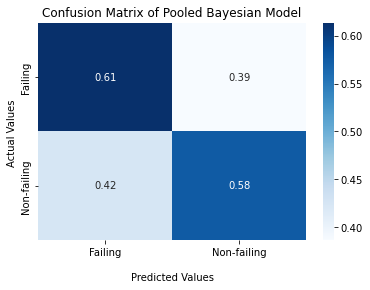

In [8]:
plot_confusion(y, y_pred, title='Confusion Matrix of Pooled Bayesian Model')

## Hyperparameter Optimization

In [9]:
# hyperparameter optimization with optuna
def objective(trial, classifier_name):
    assert classifier_name in ['SVC', 'RF', 'XGB', 'GBDT']
    if classifier_name == 'SVC':
        svc_deg = trial.suggest_int('svc_deg', 1, 10)
        svc_c = trial.suggest
        classifier_obj = SVC(degree=svc_deg, gamma='auto')
        
    elif classifier_name == 'RF':
        rf_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators)
    
    elif classifier_name == 'XGB':
        xgb_eta = trial.suggest_float('xgb_eta', 0., 1.)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 1, 20)
        classifier_obj = xgb.XGBClassifier(eta=xgb_eta, max_depth=xgb_max_depth,
                                           enable_categorical=True, use_label_encoder=False)
        
    else:
        gbdt_n_estimators = trial.suggest_int('gbdt_n_estimators', 100, 1000)
        gbdt_lr = trial.suggest_float('gbdt_lr', 0.01, 1.)
        classifier_obj = lgb.LGBMClassifier(n_estimators=gbdt_n_estimators, learning_rate=gbdt_lr)
        
    score = sklearn.model_selection.cross_val_score(classifier_obj, train_x, train_y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [95]:
# Optimize SVC
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='SVC'), n_trials=10)

[I 2022-04-19 22:32:54,956] A new study created in memory with name: no-name-07609984-a138-4529-a1d0-8122ef33cbbe
[I 2022-04-19 22:32:56,267] Trial 0 finished with value: 0.6176434676434676 and parameters: {'svc_c': 371.6029208635379, 'svc_deg': 6}. Best is trial 0 with value: 0.6176434676434676.
[I 2022-04-19 22:32:56,788] Trial 1 finished with value: 0.5051194836909122 and parameters: {'svc_c': 5.211338796181748e-07, 'svc_deg': 6}. Best is trial 0 with value: 0.6176434676434676.
[I 2022-04-19 22:32:57,302] Trial 2 finished with value: 0.5682626896912611 and parameters: {'svc_c': 2.6210694837658473, 'svc_deg': 5}. Best is trial 0 with value: 0.6176434676434676.
[I 2022-04-19 22:33:15,861] Trial 3 finished with value: 0.6672422815279958 and parameters: {'svc_c': 2112343.8569213776, 'svc_deg': 7}. Best is trial 3 with value: 0.6672422815279958.
[I 2022-04-19 22:33:47,988] Trial 4 finished with value: 0.6774986917844061 and parameters: {'svc_c': 6864865.398448115, 'svc_deg': 9}. Best is 

[I 2022-04-19 22:52:27,754] Trial 41 finished with value: 0.6655416012558869 and parameters: {'svc_c': 7461422.694083228, 'svc_deg': 8}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:52:43,788] Trial 42 finished with value: 0.6723704866562009 and parameters: {'svc_c': 1718157.5496380676, 'svc_deg': 10}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:53:51,646] Trial 43 finished with value: 0.6552939124367696 and parameters: {'svc_c': 826471215.7204027, 'svc_deg': 9}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:54:36,520] Trial 44 finished with value: 0.6690040118611548 and parameters: {'svc_c': 19365340.440191716, 'svc_deg': 7}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:55:26,753] Trial 45 finished with value: 0.6758067329495901 and parameters: {'svc_c': 16080127.30509432, 'svc_deg': 8}. Best is trial 8 with value: 0.6843101343101342.
[I 2022-04-19 22:55:26,811] Trial 46 finished with value: 0.624507238792

[I 2022-04-19 23:15:14,705] Trial 83 finished with value: 0.6416099773242631 and parameters: {'svc_c': 27702.864151351223, 'svc_deg': 4}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:17,230] Trial 84 finished with value: 0.6638060352346066 and parameters: {'svc_c': 229125.76444782582, 'svc_deg': 2}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:25,319] Trial 85 finished with value: 0.6808826094540379 and parameters: {'svc_c': 785441.864486189, 'svc_deg': 2}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:25,823] Trial 86 finished with value: 0.5051194836909122 and parameters: {'svc_c': 0.0007568020474464676, 'svc_deg': 2}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:25,859] Trial 87 finished with value: 0.5051194836909122 and parameters: {'svc_c': 1.9988323331827892e-09, 'svc_deg': 1}. Best is trial 58 with value: 0.6860282574568289.
[I 2022-04-19 23:15:53,311] Trial 88 finished with value: 0.

In [104]:
# Optimize RF
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='RF'), n_trials=100)

[I 2022-04-19 23:27:12,690] A new study created in memory with name: no-name-d2c58c0c-3d8e-4765-b55a-f4cec163a8c9
[I 2022-04-19 23:27:14,825] Trial 0 finished with value: 0.7543694400837259 and parameters: {'n_estimators': 616}. Best is trial 0 with value: 0.7543694400837259.
[I 2022-04-19 23:27:16,113] Trial 1 finished with value: 0.7560962846677133 and parameters: {'n_estimators': 570}. Best is trial 1 with value: 0.7560962846677133.
[I 2022-04-19 23:27:17,597] Trial 2 finished with value: 0.7560701203558345 and parameters: {'n_estimators': 719}. Best is trial 1 with value: 0.7560962846677133.
[I 2022-04-19 23:27:19,164] Trial 3 finished with value: 0.7663003663003662 and parameters: {'n_estimators': 787}. Best is trial 3 with value: 0.7663003663003662.
[I 2022-04-19 23:27:20,966] Trial 4 finished with value: 0.7543694400837259 and parameters: {'n_estimators': 975}. Best is trial 3 with value: 0.7663003663003662.
[I 2022-04-19 23:27:22,668] Trial 5 finished with value: 0.754369440083

[I 2022-04-19 23:27:57,876] Trial 46 finished with value: 0.7629077271934416 and parameters: {'n_estimators': 707}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:27:58,827] Trial 47 finished with value: 0.7628990057561486 and parameters: {'n_estimators': 719}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:27:59,709] Trial 48 finished with value: 0.7492673992673993 and parameters: {'n_estimators': 661}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:00,511] Trial 49 finished with value: 0.7526600383743242 and parameters: {'n_estimators': 618}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:01,553] Trial 50 finished with value: 0.7560788417931276 and parameters: {'n_estimators': 801}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:02,645] Trial 51 finished with value: 0.7509593581022153 and parameters: {'n_estimators': 859}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04

[I 2022-04-19 23:28:40,599] Trial 93 finished with value: 0.7509593581022153 and parameters: {'n_estimators': 850}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:41,541] Trial 94 finished with value: 0.750976800976801 and parameters: {'n_estimators': 714}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:42,735] Trial 95 finished with value: 0.7577882435025293 and parameters: {'n_estimators': 908}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:43,820] Trial 96 finished with value: 0.7560613989185417 and parameters: {'n_estimators': 829}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:44,602] Trial 97 finished with value: 0.7577795220652362 and parameters: {'n_estimators': 597}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-19 23:28:45,524] Trial 98 finished with value: 0.7577882435025293 and parameters: {'n_estimators': 681}. Best is trial 35 with value: 0.7663090877376592.
[I 2022-04-

In [21]:
# Optimize XGB
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='XGB'), n_trials=100)

[I 2022-04-20 17:43:04,502] A new study created in memory with name: no-name-55215219-098d-4171-9fb2-10ba189e38d6
[I 2022-04-20 17:43:11,824] Trial 0 finished with value: 0.7406506192220478 and parameters: {'xgb_eta': 0.8183157513773635, 'xgb_max_depth': 19}. Best is trial 0 with value: 0.7406506192220478.
[I 2022-04-20 17:43:16,978] Trial 1 finished with value: 0.733813012384441 and parameters: {'xgb_eta': 0.38758934790341815, 'xgb_max_depth': 4}. Best is trial 0 with value: 0.7406506192220478.
[I 2022-04-20 17:43:24,153] Trial 2 finished with value: 0.7441043083900226 and parameters: {'xgb_eta': 0.9041868439215857, 'xgb_max_depth': 9}. Best is trial 2 with value: 0.7441043083900226.
[I 2022-04-20 17:43:31,308] Trial 3 finished with value: 0.7543345543345543 and parameters: {'xgb_eta': 0.7371050805752323, 'xgb_max_depth': 12}. Best is trial 3 with value: 0.7543345543345543.
[I 2022-04-20 17:43:37,687] Trial 4 finished with value: 0.7696842839699983 and parameters: {'xgb_eta': 0.849258

[I 2022-04-20 17:46:58,680] Trial 39 finished with value: 0.7645909645909645 and parameters: {'xgb_eta': 0.19312132639232693, 'xgb_max_depth': 18}. Best is trial 38 with value: 0.7713936856794.
[I 2022-04-20 17:47:11,204] Trial 40 finished with value: 0.7833333333333332 and parameters: {'xgb_eta': 0.042299312224789304, 'xgb_max_depth': 15}. Best is trial 40 with value: 0.7833333333333332.
[I 2022-04-20 17:47:24,665] Trial 41 finished with value: 0.778213849642421 and parameters: {'xgb_eta': 0.05668389195216907, 'xgb_max_depth': 15}. Best is trial 40 with value: 0.7833333333333332.
[I 2022-04-20 17:47:38,015] Trial 42 finished with value: 0.7730943659515089 and parameters: {'xgb_eta': 0.04435038899694205, 'xgb_max_depth': 15}. Best is trial 40 with value: 0.7833333333333332.
[I 2022-04-20 17:47:51,281] Trial 43 finished with value: 0.7833507762079192 and parameters: {'xgb_eta': 0.05444239998598849, 'xgb_max_depth': 15}. Best is trial 43 with value: 0.7833507762079192.
[I 2022-04-20 17:4

[I 2022-04-20 17:55:05,166] Trial 79 finished with value: 0.7730943659515089 and parameters: {'xgb_eta': 0.058263018532507094, 'xgb_max_depth': 12}. Best is trial 71 with value: 0.7935723007151578.
[I 2022-04-20 17:55:17,631] Trial 80 finished with value: 0.7697104482818768 and parameters: {'xgb_eta': 0.12567928478780932, 'xgb_max_depth': 14}. Best is trial 71 with value: 0.7935723007151578.
[I 2022-04-20 17:55:31,438] Trial 81 finished with value: 0.786734693877551 and parameters: {'xgb_eta': 0.03483886598542405, 'xgb_max_depth': 19}. Best is trial 71 with value: 0.7935723007151578.
[I 2022-04-20 17:55:45,563] Trial 82 finished with value: 0.7833246118960405 and parameters: {'xgb_eta': 0.03718311433416151, 'xgb_max_depth': 18}. Best is trial 71 with value: 0.7935723007151578.
[I 2022-04-20 17:55:58,079] Trial 83 finished with value: 0.7731030873888017 and parameters: {'xgb_eta': 0.09436434949748461, 'xgb_max_depth': 17}. Best is trial 71 with value: 0.7935723007151578.
[I 2022-04-20 1

In [14]:
# Optimize GBDT
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, classifier_name='GBDT'), n_trials=100)

[I 2022-04-20 21:59:45,136] A new study created in memory with name: no-name-690d9b79-63af-4ecb-99c2-0935966b1115
[I 2022-04-20 21:59:45,269] Trial 0 finished with value: 0.7132987910189982 and parameters: {'gbdt_n_estimators': 891, 'gbdt_lr': 0.3328460866720329}. Best is trial 0 with value: 0.7132987910189982.
[I 2022-04-20 21:59:45,363] Trial 1 finished with value: 0.7115716753022453 and parameters: {'gbdt_n_estimators': 629, 'gbdt_lr': 0.8088620388218714}. Best is trial 0 with value: 0.7132987910189982.
[I 2022-04-20 21:59:45,583] Trial 2 finished with value: 0.7564766839378239 and parameters: {'gbdt_n_estimators': 809, 'gbdt_lr': 0.01864227016860461}. Best is trial 2 with value: 0.7564766839378239.
[I 2022-04-20 21:59:45,653] Trial 3 finished with value: 0.7132987910189983 and parameters: {'gbdt_n_estimators': 276, 'gbdt_lr': 0.4424432424506073}. Best is trial 2 with value: 0.7564766839378239.
[I 2022-04-20 21:59:45,765] Trial 4 finished with value: 0.7184801381692574 and parameter

[I 2022-04-20 21:59:51,551] Trial 38 finished with value: 0.7184801381692573 and parameters: {'gbdt_n_estimators': 476, 'gbdt_lr': 0.14791314313172751}. Best is trial 2 with value: 0.7564766839378239.
[I 2022-04-20 21:59:51,666] Trial 39 finished with value: 0.7029360967184802 and parameters: {'gbdt_n_estimators': 665, 'gbdt_lr': 0.3784002013891583}. Best is trial 2 with value: 0.7564766839378239.
[I 2022-04-20 21:59:51,782] Trial 40 finished with value: 0.7115716753022453 and parameters: {'gbdt_n_estimators': 781, 'gbdt_lr': 0.2796685827495928}. Best is trial 2 with value: 0.7564766839378239.
[I 2022-04-20 21:59:52,010] Trial 41 finished with value: 0.7633851468048359 and parameters: {'gbdt_n_estimators': 849, 'gbdt_lr': 0.011464813403528895}. Best is trial 41 with value: 0.7633851468048359.
[I 2022-04-20 21:59:52,246] Trial 42 finished with value: 0.7202072538860104 and parameters: {'gbdt_n_estimators': 862, 'gbdt_lr': 0.08139171612870762}. Best is trial 41 with value: 0.763385146804

[I 2022-04-20 21:59:55,777] Trial 77 finished with value: 0.7512953367875648 and parameters: {'gbdt_n_estimators': 130, 'gbdt_lr': 0.18383820136358608}. Best is trial 54 with value: 0.7772020725388601.
[I 2022-04-20 21:59:55,855] Trial 78 finished with value: 0.7616580310880829 and parameters: {'gbdt_n_estimators': 256, 'gbdt_lr': 0.03422605501041903}. Best is trial 54 with value: 0.7772020725388601.
[I 2022-04-20 21:59:55,960] Trial 79 finished with value: 0.7236614853195164 and parameters: {'gbdt_n_estimators': 339, 'gbdt_lr': 0.11631459823306803}. Best is trial 54 with value: 0.7772020725388601.
[I 2022-04-20 21:59:56,063] Trial 80 finished with value: 0.7288428324697754 and parameters: {'gbdt_n_estimators': 372, 'gbdt_lr': 0.08172349510151374}. Best is trial 54 with value: 0.7772020725388601.
[I 2022-04-20 21:59:56,118] Trial 81 finished with value: 0.7633851468048359 and parameters: {'gbdt_n_estimators': 158, 'gbdt_lr': 0.03873794789577942}. Best is trial 54 with value: 0.77720207

## Optimized Baseline Analysis

### b) Random Forest

accuracy for random forest: 66.15384615384615%


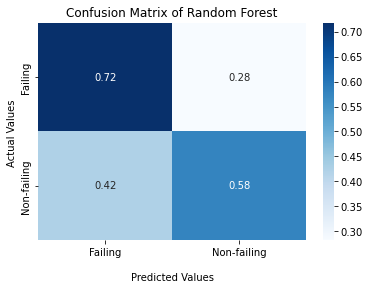

In [16]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=98)
rf_clf.fit(train_x, train_y)
rf_y_pred = rf_clf.predict(test_x)
acc = rf_clf.score(test_x, test_y)
print(f'accuracy for random forest: {acc * 100}%')

plot_confusion(test_y, rf_y_pred, title='Confusion Matrix of Random Forest')

### c) SVC

accuracy for SVC: 67.6923076923077%


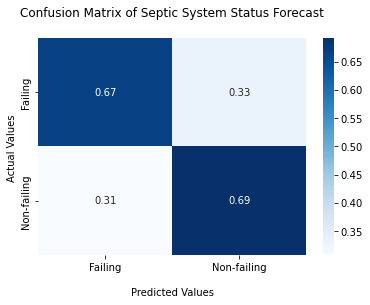

In [12]:
# SVC
svc_clf = SVC(degree=3)
svc_clf.fit(train_x, train_y)
acc = svc_clf.score(test_x, test_y)
svc_y_pred = svc_clf.predict(test_x)
print(f'accuracy for SVC: {acc * 100}%')

plot_confusion(test_y, svc_y_pred)

### d) XGBoost

[23:09:08] WARNING: ../src/learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:09:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy for XGBoost: 67.6923076923077%


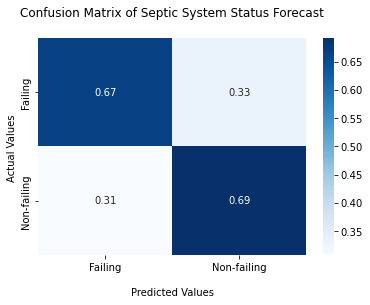

In [14]:
# XGBoost
xgb_clf = xgb.XGBClassifier(
    eta=0.03875457352141243, max_depth=12, enable_categorical=True, use_label_encoder=False
)

xgb_clf.fit(train_x, train_y)
acc = xgb_clf.score(test_x, test_y)
xgb_y_pred = xgb_clf.predict(test_x)
print(f'accuracy for XGBoost: {acc * 100}%')

plot_confusion(test_y, xgb_y_pred)

### e) Gradient Boosting Decision Tree (GBDT)

accuracy for GBDT: 73.84615384615385%


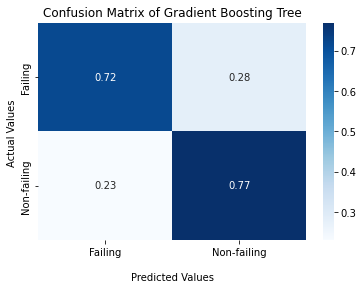

In [15]:
# LightGBM
gbdt_clf = lgb.LGBMClassifier(n_estimators=302, learning_rate=0.011684687770816824)
gbdt_clf.fit(train_x, train_y)
acc = gbdt_clf.score(test_x, test_y)
gbdt_y_pred = gbdt_clf.predict(test_x)
print(f'accuracy for GBDT: {acc * 100}%')

plot_confusion(test_y, gbdt_y_pred, title='Confusion Matrix of Gradient Boosting Tree')